In [1]:
### In this document I will be analysing my apple music library to see what conclusions I can draw from the data ###

In [2]:
!pip install pandas
!pip install matplotlib seaborn

In [3]:
import plistlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import normaltest
from scipy.stats import linregress
from scipy.stats import kruskal
from scipy.stats import levene
from scipy.stats import median_test

# Loading the iTunes XML file
with open('apple music library.xml','rb') as f:
    plist = plistlib.load(f)

# Extracting necessary track info
tracks = plist['Tracks']
track_list = []

for track_id, track in tracks.items():
    # We only want tracks with the required fields
    if all (k in track for k in ('Name', 'Artist', 'Play Count', 'Genre', 'Release Date')):
        track_list.append({
            'Name': track.get('Name'),
            'Artist': track.get('Artist'),
            'Album': track.get('Album'),
            'Play Count': track.get('Play Count',0),
            'Genre': track.get('Genre'),
            'Release Date': track.get('Release Date'),
            'Date Added': track.get('Date Added'),
            'Total Time (s)': track.get('Total Time', 0) / 1000})

# Create dataframe

df = pd.DataFrame(track_list)

# Remove songs with play count of 0

df = df[df['Play Count'] > 0]

# Combining genres due to common artists in both

df = df.replace(('Adult Alternative','Hip-Hop','TV Soundtrack'),('Alternative','Hip-Hop/Rap','Soundtrack'))

## Creating a list of the top 10 genres by average plays per song for genres with at least 10 songs

# Group by genre
genre_stats = df.groupby('Genre').agg({
    'Play Count': 'mean',
    'Name': 'count'  # Number of songs per genre
}).rename(columns={'Name': 'Track Count'})

# Filter to genres with at least 10 songs
genre_stats = genre_stats[genre_stats['Track Count'] >= 10]

# Get top 10 genres by average play count
top_genres = genre_stats.sort_values(by='Play Count', ascending=False).head(10).index

# Keeping only songs in top genres
df_clean = df[df['Genre'].isin(top_genres)].reset_index(drop=True)

In [4]:
# To this point have loaded in my dataset, removed play counts of zero, concatenated genres that are poorly distinguished by apple music, removed any genres with less than 10 songs in them and only kept the top 10 genres by play count per song

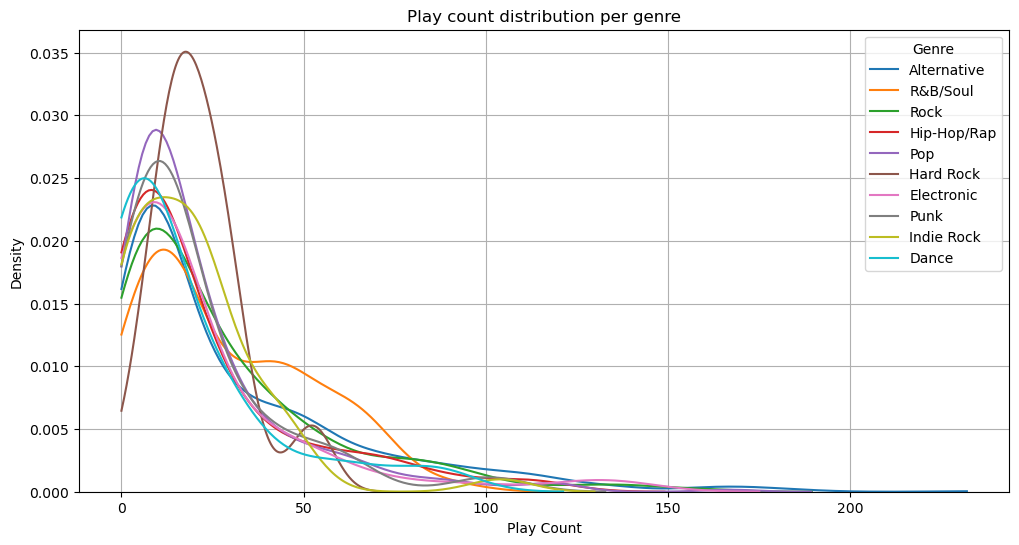

In [5]:
# Setting up plot
plt.figure(figsize=(12,6))

# Loop through genres and plot KDE
for genre in top_genres:
    indiv_genre = df_clean[df_clean['Genre'] == genre]
    sns.kdeplot(indiv_genre['Play Count'], label = genre, fill = False, common_norm = False, clip=(0,232))

# To make it pretty
plt.title('Play count distribution per genre')
plt.xlabel('Play Count')
plt.ylabel('Density')
plt.legend(title = 'Genre', loc = 'upper right')
plt.grid(True)
plt.show()

In [6]:
# This data does not appear normal, so to ensure this we will run a Shapiro-Wilk test

In [7]:
# Test for normaility
normal_test_results = []

# Loop through genres
for genre in top_genres:
    indiv_genre = df[df['Genre'] == genre]['Play Count']
    stat, p = normaltest(indiv_genre)
    normal_test_results.append({
        'Genre' : genre,
        '# of Songs' : len(indiv_genre),
        'Stat' : round(stat,3),
        'p-Value' : round(p,10),
        'Normal?' : 'Yes' if p > 0.05 else 'No'})

test_results_df = pd.DataFrame(normal_test_results)
test_results_df

,Genre,# of Songs,Stat,p-Value,Normal?
0,Alternative,1210,442.516,0.000000e+00,No
1,R&B/Soul,96,9.249,9.809854e-03,No
2,Rock,365,133.527,0.000000e+00,No
3,Hip-Hop/Rap,121,48.084,0.000000e+00,No
4,Pop,345,187.620,0.000000e+00,No
5,Hard Rock,39,10.704,4.738971e-03,No
6,Electronic,61,50.455,0.000000e+00,No
7,Punk,33,29.117,4.757000e-07,No
8,Indie Rock,47,40.737,1.400000e-09,No
9,Dance,40,23.522,7.801200e-06,No


In [8]:
# As we can see the curve does not follow a normal distribution, but all genres do seem to follow a similar pattern of distribution, with the largest outlier being hard rock

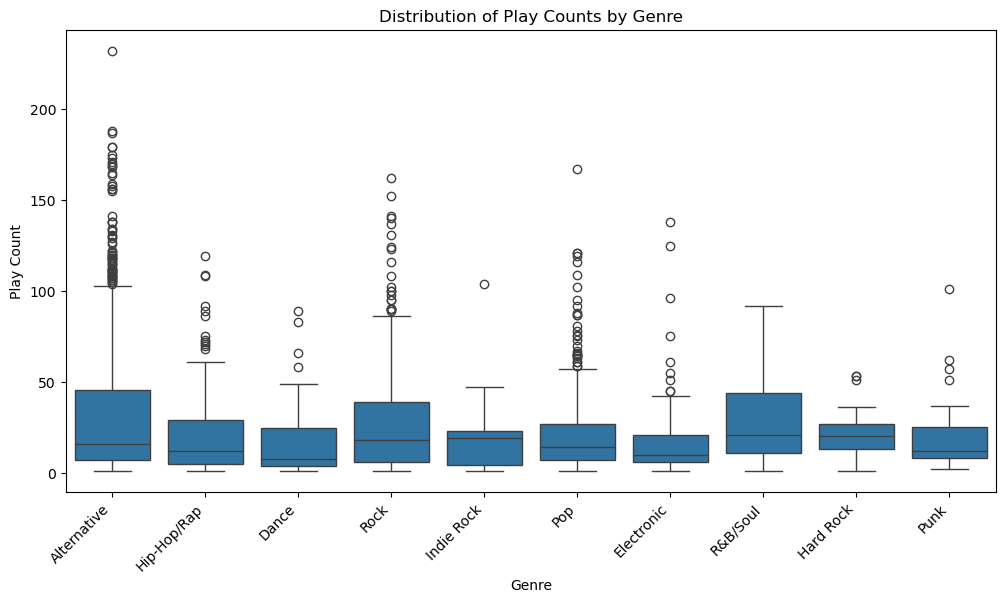

In [9]:
# Plotting a boxplot for play count by genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='Play Count', data=df_clean)

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Play Counts by Genre')
plt.xlabel('Genre')
plt.ylabel('Play Count')
plt.show()

In [10]:
# The above boxplot would suggest that there is no homogeny of variance, to check this we will use Levene's test

In [11]:
# Testing for homogeny of variance using Levene's test
groups = [group['Play Count'].values for name, group in df_clean.groupby('Genre')]
stat, p = levene(*groups)
print(f"Levene's test statistic = {stat:.2f}, p = {p:.10f}")

Levene's test statistic = 6.47, p = 0.0000000039


In [12]:
# As p < 0.05, this confirms what the boxplot was suggesting, meaning there is significant spread of play counts across genres. Because there is no homogeny of variance or normality, we will have to use a non-parametric test.

In [13]:
# Testing for play count distribution between genres using the Kruskal-Wallis test
stat, p = kruskal(*groups)
print(f"H statistic = {stat:.2f}, p = {p:.10f}")

H statistic = 36.41, p = 0.0000335337


In [14]:
# Due to the large number of outliers in the data its a smart idea to run mood's median test to double check

In [15]:
# Running Mood's Median Test
stat, p, med, table = median_test(*groups)
print(f"Chi Squared = {stat:.2f}, p = {p:.10f}")

Chi Squared = 43.95, p = 0.0000014423


In [16]:
# Between the box plot, Kruskal-Wallis and Mood's median, we can see that there is statistical significance to suggest there is a difference between median play counts across at least 1 genre

In [17]:
# Create correlation for chosen columns
df_corr = df_clean[['Play Count', 'Total Time (s)', 'Date Added']]
df_corr.corr()

,Play Count,Total Time (s),Date Added
Play Count,1.000000,-0.051140,-0.257254
Total Time (s),-0.051140,1.000000,-0.051434
Date Added,-0.257254,-0.051434,1.000000


In [18]:
# As seen in the above table, there is no strong correlation to play count for song duration or date added. The strongest correlation is date added at approximately -0.26. This is the expected result as you would expect play count to decrease the less time a song has been in the library.

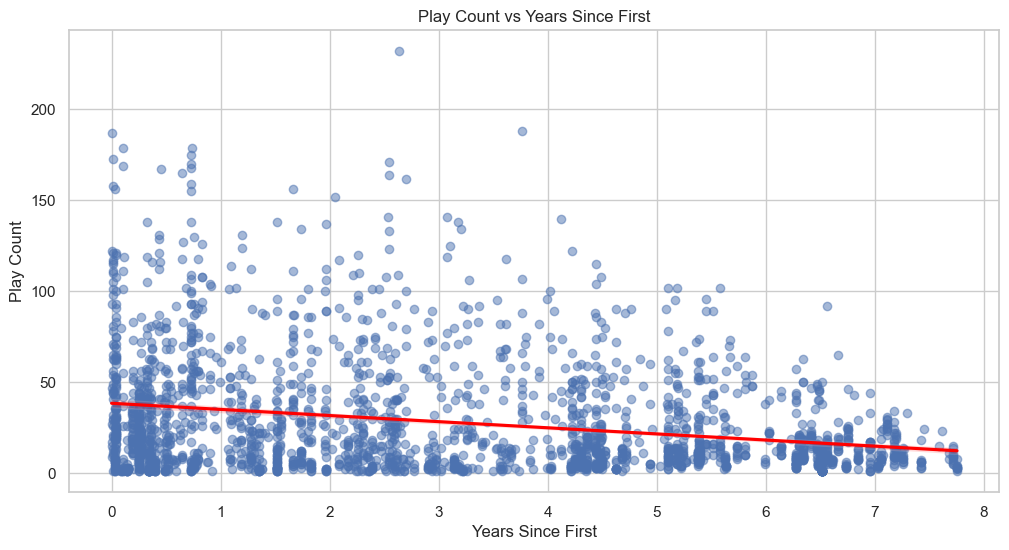

In [19]:
# Converting date added to integer type
df_clean['Date Added'] = pd.to_datetime(df_clean['Date Added'])
df_clean['Years Since First'] = (df_clean['Date Added'] - df_clean['Date Added'].min()).dt.days/365

# Plotting play count against date added
sns.set(style="whitegrid")
plt.figure(figsize =(12,6))
sns.regplot(x='Years Since First', y='Play Count', data=df_clean, scatter_kws={'alpha': 0.5}, line_kws={'color':'red'})
plt.title('Play Count vs Years Since First')
plt.xlabel('Years Since First')
plt.ylabel('Play Count')
plt.grid(True)
plt.show()

In [20]:
# Above you can see the expected down trend along the top of the graph but with a lot of noise along the bottom. This can be partly explained by albums and songs that were added to the library but then never really listened to. If this test were to be repeat with a dataset of songs that are on regular rotation you would imagine we would see a much stronger negative correlation.

In [21]:
# Calculating the gradient of the regression line
slope, *_ = linregress(df_clean['Years Since First'],df_clean['Play Count'])
print(f'The gradient of the line is: {slope}')

The gradient of the line is: -3.370165222035746


In [22]:
# Based on statistical testing and visual analysis, song length, and date added do not appear to significantly influence how often I listen to a song, with genre having some measurable effect. Listening behavior seems more driven by personal or contextual factors. Sometimes you play breezeblocks by alt-j too much in sixth form and it becomes a significant outlier.

# See full discussion in the README.txt file